# Similarity-based Learning - *k*-Nearest-Neighbor

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sn # For data sets

# Create a K-Nearest Neighbors Algorithm from Scratch in Python

- https://towardsdatascience.com/create-your-own-k-nearest-neighbors-algorithm-in-python-eb7093fc6339
- https://github.com/turnerluke/ML-algos/blob/main/knn/knn.py


Define functions and a Python class for the ML model

In [3]:
def most_common(lst):
    return max(set(lst), key=lst.count)


def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))


class KNeighborsClassifier():
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])

        return list(map(most_common, neighbors))

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy

## Example with IRIS data set

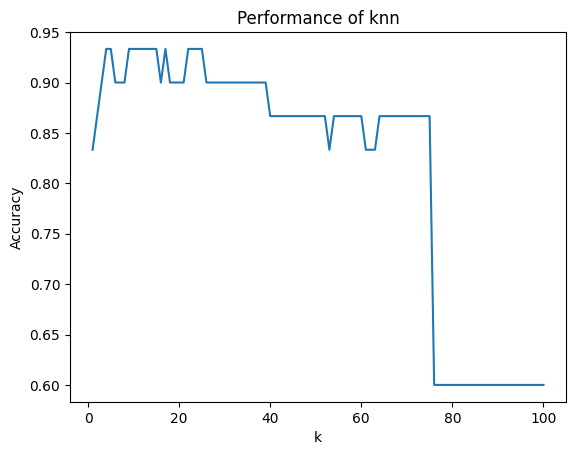

In [4]:
# Unpack the iris dataset, from UCI Machine Learning Repository
iris = datasets.load_iris()
X = iris['data']
y = iris['target']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocess data
ss = StandardScaler().fit(X_train)
X_train, X_test = ss.transform(X_train), ss.transform(X_test)

# Test knn model across varying ks
accuracies = []
ks = range(1, 101)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(X_train, y_train)
    accuracy = knn.evaluate(X_test, y_test)
    accuracies.append(accuracy)

# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()

## Penguins

In [5]:
penguins = sn.load_dataset('penguins')
print(penguins.shape)

(344, 7)


In [6]:
penguins.groupby(['species', 'island', 'sex'])['body_mass_g'] \
    .count() \
    .reset_index() \
    .rename({'body_mass_g': 'N'}, axis=1)

,species,island,sex,N
0,Adelie,Biscoe,Female,22
1,Adelie,Biscoe,Male,22
2,Adelie,Dream,Female,27
3,Adelie,Dream,Male,28
4,Adelie,Torgersen,Female,24
5,Adelie,Torgersen,Male,23
6,Chinstrap,Dream,Female,34
7,Chinstrap,Dream,Male,34
8,Gentoo,Biscoe,Female,58
9,Gentoo,Biscoe,Male,61


# Text embedding - Vector Database

In [7]:
! ls /data/IFI8410/sess01/sentiment_labelled_sentences/*labelled.txt

/data/IFI8410/sess01/sentiment_labelled_sentences/amazon_cells_labelled.txt
/data/IFI8410/sess01/sentiment_labelled_sentences/imdb_labelled.txt
/data/IFI8410/sess01/sentiment_labelled_sentences/yelp_labelled.txt


In [8]:
reviews =  pd.read_csv('/data/IFI8410/sess01/sentiment_labelled_sentences/yelp_labelled.txt', delimiter='\t', header=None)
reviews.columns = ['text', 'sentiment']
print(f"Number of records: {reviews.shape[0]:1}")

Number of records: 1000


In [9]:
reviews.head()

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## OpenAI
Using OpenAI API for Embedding

https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

In [10]:
!mkdir -p output

In [11]:
!pip install pydantic 1.8.2
!pip install openai

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement 1.8.2 (from versions: none)
ERROR: No matching distribution found for 1.8.2

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.8 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.8 -m pip install --upgrade pip


In [12]:
# Load your OpenAI API key from a secure location
API_KEY = open('/home/mjack6/.secrets/openai_mjack6_gsu_edu.apikey', 'r').read().strip()
os.environ['OPENAI_API_KEY'] = API_KEY

from openai import OpenAI
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

# Do not execute accidentilly
if False and not os.path.isfile('output/embedded_reviews.csv'):
    reviews['ada_embedding'] = reviews.text.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
    reviews.to_csv('output/embedded_reviews.csv', index=False)

In [13]:
reviews.head()

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Load embedded reviews

In [16]:
reviews2 = pd.read_csv('output/embedded_reviews.csv')
reviews2.dtypes

text         object
sentiment     int64
dtype: object

In [17]:
reviews2['ada_embedding'] = reviews2.ada_embedding.apply(eval).apply(np.array)

AttributeError: 'DataFrame' object has no attribute 'ada_embedding'

## Faiss: A library for efficient similarity search

https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/

In [ ]:
v = reviews2.iloc[0].ada_embedding
d = len(v)
print(f"Dimension: {d:,}")

In [ ]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(d)   # build the index, d=size of vectors 

In [ ]:
xb = np.stack(reviews2.ada_embedding, axis=0)
print(xb.shape)

In [ ]:
xb[:10, :5]

In [ ]:
# here we assume xb contains a n-by-d numpy matrix of type float32
index.add(xb)                  # add vectors to the index
print(f"Number of records: {index.ntotal:,}")

In [ ]:
reviews2.iloc[17].text

In [ ]:
k = 4                          # we want 4 similar vectors

xq = np.stack([reviews2.iloc[17].ada_embedding])
D, I = index.search(xq, k)     # actual search
print(I)
print(D)


In [ ]:
for idx in I[0]:
    print(f"{reviews2.iloc[idx].text}")

### Ask questions

In [ ]:
q_text = "How is the pizza?"
q_vec = get_embedding(q_text)

xq = np.stack([q_vec])
D, I = index.search(xq, k)     # actual search

for idx in I[0]:
    print(f"{reviews2.iloc[idx].text}")

### Sentiment Anlysis

In [ ]:
input_text = "The steak was raw"
input_vec = get_embedding(input_text)

k = 5 
D, I = index.search(np.stack([input_vec]), k)     # actual search
matches = reviews2.iloc[I[0]][['text', 'sentiment']].copy()
matches['distance'] = D[0]
weights = 1.0/(1+D[0])
matches['weight'] = weights/weights.sum()
display(matches)
sentiment = np.sum(matches.sentiment * matches.weight)
print(f"Sentiment: {sentiment}")

In [ ]:
k = 5 

while True:
    print("\n\nEnter review: (Hit <Enter> to quit)")
    q_text = input()
    if len(q_text.strip()) == 0:
        break

    q_vec = get_embedding(q_text)
    D, I = index.search(np.stack([q_vec]), k)     # actual search
    
    matches = reviews2.iloc[I[0]][['text', 'sentiment']].copy()
    matches['distance'] = D[0]
    weights = 1.0/(1+D[0])
    matches['weight'] = weights/weights.sum()
    display(matches)
    
    sentiment = np.sum(matches.sentiment * matches.weight)
    print(f"Sentiment for: '{q_text:60}' is {sentiment:.1f}")

# Reading
- Scikit-Learn Preprocessing https://scikit-learn.org/stable/modules/preprocessing.html 
- https://towardsdatascience.com/create-your-own-k-nearest-neighbors-algorithm-in-python-eb7093fc6339
- https://medium.com/gft-engineering/using-text-embeddings-and-approximate-nearest-neighbour-search-to-explore-shakespeares-plays-29e6bde05a16
- https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
- https://platform.openai.com/docs/guides/embeddings/use-cases
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Spending on OpenAI for this experiment
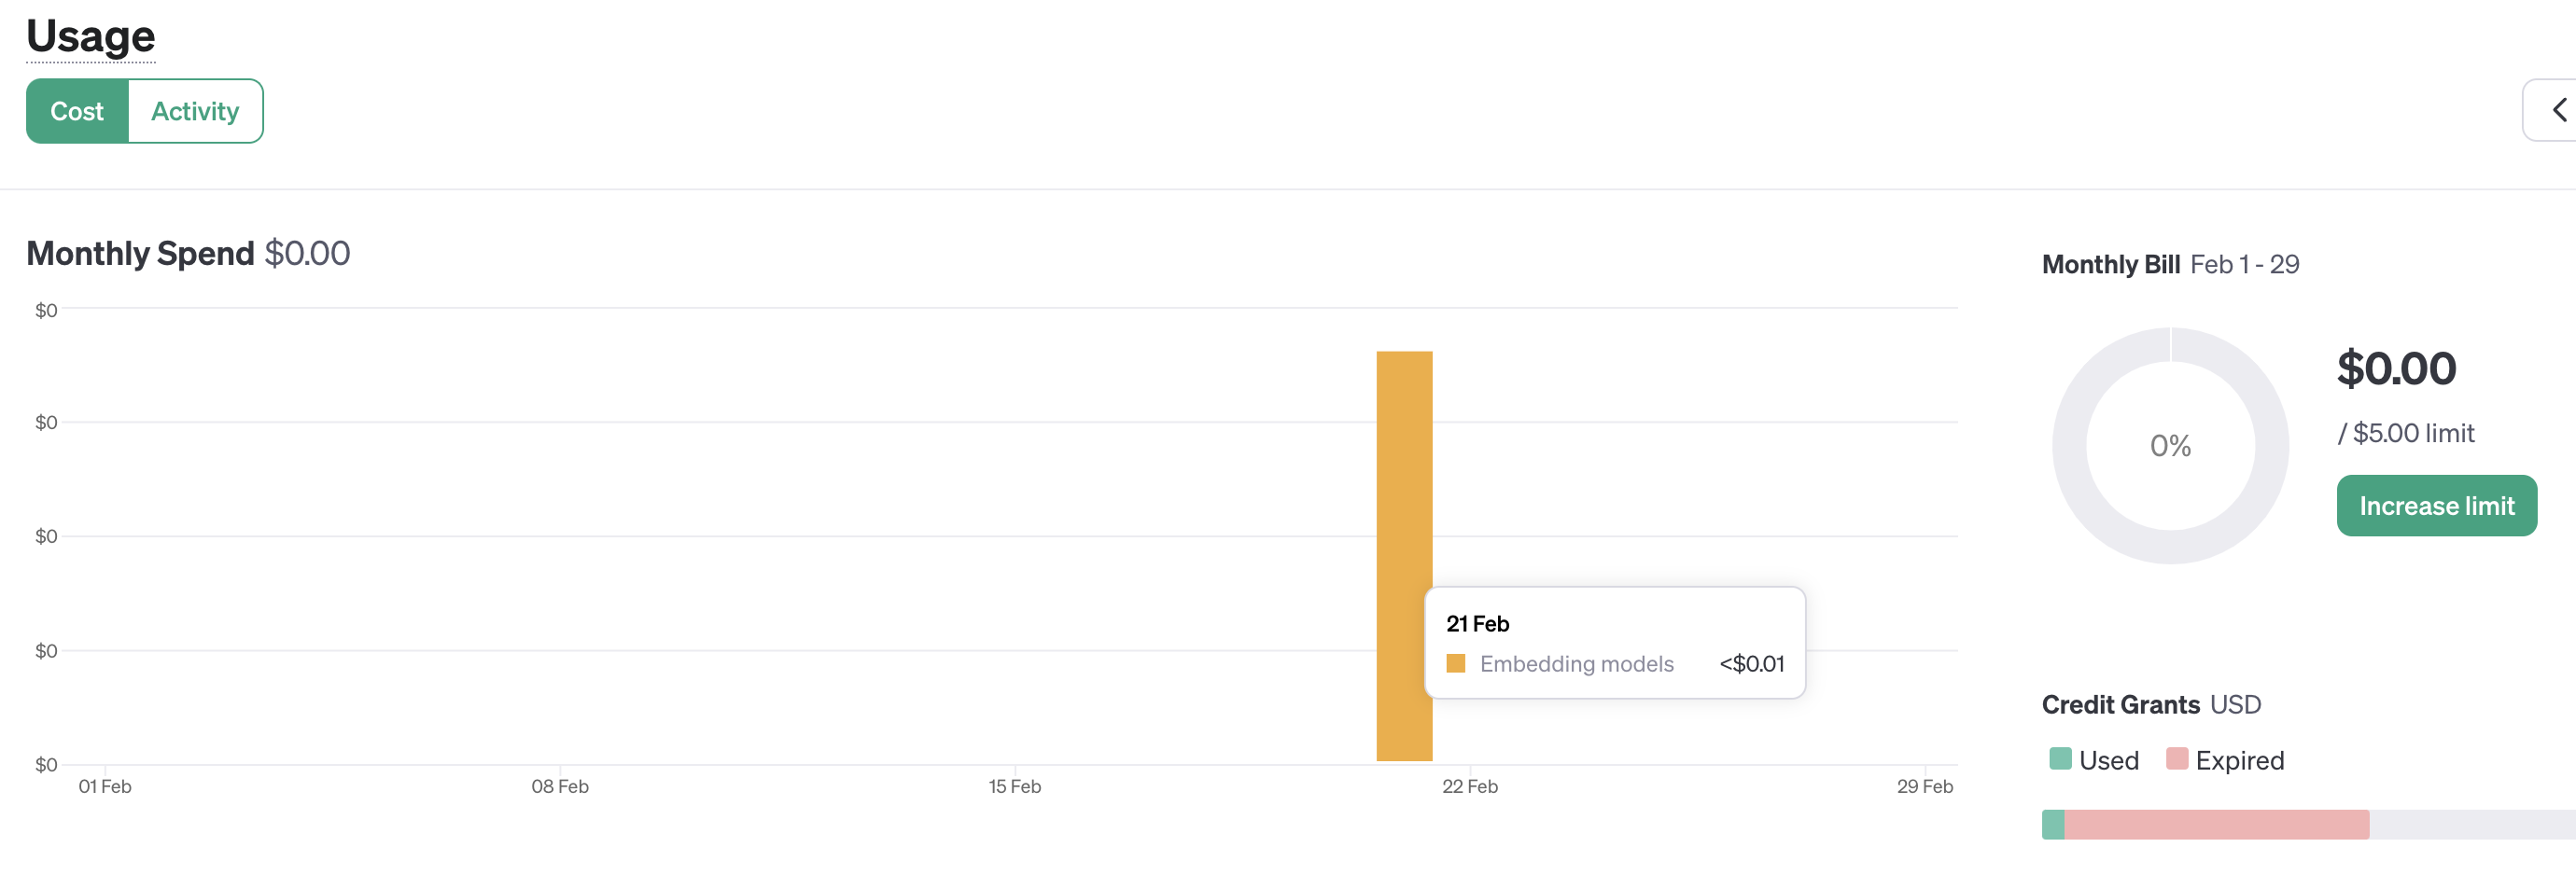